# Построение вопросно-ответной системы с использованием RAG

План проведения экспериментов:

1. Использовать готовую модель Word2Vec, преобразовать колонку с контекстами в вектора, провести брутфорсом поиск для каждого вопроса в БД (использовать косинусную близость и эвклидово расстояние), посчитать качество.


2. Обучить свою модель Word2Vec, преобразовать колонку с контекстами в вектора, провести брутфорсом поиск для каждого вопроса в БД (использовать косинусную близость и эвклидово расстояние), посчитать качество.

3. Обогатить датасет, увеличить до 100 000 строк и замерить время извлечения ответа на маленьком (12 000) и большом (100 000) датасете.

4. Поместить полученные с помощью word2vec векторы (маленький датасет 12000) в БД Qdrant.

5. Замерить качество.

6. Замерить время извлечения ответа и сравнить с пунктом 3.

7. Увеличить кол-во векторов в БД, замерить время.

### импорты

In [ ]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_score


import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

tokenizer = WordPunctTokenizer()

import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

In [3]:
# фиксируем seed
random.seed(42)
np.random.seed(42)

### загрузка датасета

In [246]:
# загрузка csv файла из google drive
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t' -O full_dataset.csv

In [247]:
rag_dataset = pd.read_csv('full_dataset.csv')
rag_dataset

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...
...,...,...,...
11995,"Fuzzy's Ultra Premium Vodka\nThe Myth, The Man...",What are some of the achievements of Fuzzy Zoe...,Fuzzy Zoeller is known for his golfing success...
11996,Swedish Grand Prix rider Malin Nilsson got mar...,Who did Malin Nilsson marry on 2 June 2018?,"Malin Nilsson got married to her partner, Germ..."
11997,The Cracchiolo Law Library of the James E. Rog...,What is the Fellowship in Law Librarianship of...,The Fellowship in Law Librarianship is a progr...
11998,2nd physical eMAG store opens in Mammut\nOnlin...,Where has the second physical eMAG store been ...,The second physical eMAG store has been opened...


In [248]:
# вывод одного сэмпла
rag_dataset.values[0]

array(['Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption o

Видны посторонние символы, такие как перевод строки \n

Имеется 3 колонки и 12000 строк

In [249]:
rag_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12000 non-null  object
 1   question  11997 non-null  object
 2   answer    11997 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


In [250]:
df = rag_dataset.copy()

df.columns

Index(['context', 'question', 'answer'], dtype='object')

In [251]:
# удаление строк с пустыми значениями (None)
df = df.dropna()

In [252]:
# приведем к нижнему регистру тексты во всех колонках
df['context'] = df['context'].apply(lambda x: x.lower())
df['question'] = df['question'].apply(lambda x: x.lower())
df['answer'] = df['answer'].apply(lambda x: x.lower())

df

,context,question,answer
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...
1,rwsn collaborations\nsouthern africa self-supp...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...
2,all android applications categories\ndescripti...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...
...,...,...,...
11995,"fuzzy's ultra premium vodka\nthe myth, the man...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...
11996,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ..."
11997,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...
11998,2nd physical emag store opens in mammut\nonlin...,where has the second physical emag store been ...,the second physical emag store has been opened...


In [253]:
# удаление/замена на пробел знака перевода строки в колонке 'context'
df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))

In [254]:
# проверка на полные дубликаты
df[df.duplicated()]

,context,question,answer


In [255]:
# проверка на дубликаты в колонке context
df[df.duplicated(subset=['context'])]

,context,question,answer


In [256]:
# проверка на дубликаты в колонке answer
df[df.duplicated(subset=['answer'])]

,context,question,answer


In [257]:
# проверка на дубликаты в колонке question
df[df.duplicated(subset=['question'], keep=False)].sort_values('question')

,context,question,answer
9991,background – nectar mattress review – is this ...,what are some of the features that set the nec...,some of the features that set the nectar mattr...
6225,background – nectar mattress review – is this ...,what are some of the features that set the nec...,the nectar mattress is a reasonably priced foa...
9259,explore concrete pump operator careers and fin...,what are some of the job roles mentioned in th...,some of the job roles mentioned in the context...
9070,lead teacher jobs teacher - early childhoodnew...,what are some of the job roles mentioned in th...,some of the job roles mentioned in the context...
11587,"i'm sorry the pictures are so dark.....""someon...",what are the ingredients needed for the recipe...,the ingredients needed for the recipe are .5 c...
2599,description if i eat flour i prefer to eat rye...,what are the ingredients needed for the recipe...,the ingredients needed for the recipe are rye ...
10753,hose hook up for jet skichameleon dating sites...,what is the context about?,"the context is about various topics, including..."
8322,"""they are both comparatively late age, on n'a ...",what is the context about?,the context is a collection of various sentenc...
11483,order by popularity | order by alphabet like s...,what is the context about?,the context is about a list of titles or phras...
6217,the synthetic fragrant compounds based on 2-te...,what is the context about?,the context is about synthetic fragrant compou...


In [258]:
# удаление найденных дубликатов по 'question'
df.duplicated(subset=['question'], keep=False)
df.drop_duplicates(subset = ['question'], keep = 'first', inplace = True)


In [ ]:
# в ходе экспериментов ниже с векторами были обнаружены две строки с другим языком
df.drop(index=[7453, 10225], inplace=True)
df.reset_index(drop=True, inplace=True) # обновление индексов

In [261]:
df[7440:7455]

,context,question,answer
7448,dr. cleland has. he held executive management ...,who was appointed as the president and chief e...,neil k. warma was appointed as the president a...
7449,"5573 danbury cir, lake in the hills, il 60156 ...",what are some of the features of the property ...,"the property at 5573 danbury cir, lake in the ..."
7450,jemjem offers the refurbished apple macbook pr...,what is the discount offered by the coupon cod...,"the coupon code ""dealnews10"" cuts the price by..."
7451,one of many most crucial profit for making use...,what is one of the most crucial benefits of us...,one of the most crucial benefits of using rasp...
7452,ahora que se acerca san valentín he pensado qu...,what is the author's habit related to glass ja...,the author never throws glass jars or tins awa...
7453,【学术活动预告】numerical characterization of powder f...,who is the speaker for the lecture on numerica...,the speaker for the lecture on numerical chara...
7454,write code to test code one of the job descrip...,what are the three dominant roles in engineeri...,the three dominant roles in engineering terms ...
7455,"these financial loans produce personal debt, a...",what is the key to a bright financial future a...,the key to a bright financial future is to eff...
7456,motogp correspondent bruce allen previews the ...,who were the two main competitors in the 2011 ...,the two main competitors in the 2011 motogp se...
7457,doing a complete 180 in life: “progress is imp...,what were the new rules the person set for the...,none of the meat that they choose to eat will ...


## Word2Vec

#### Функции

1. Функция для извлечения эмбеддинга из фразы/контекста - делаем усреднение (принимает фразу и модель, отдает вектор)
2. Функция для вычисления косинусной близости и эвклидова расстояния контекстов и вопросов по датасету (принимает датафрейм, метод близости, модель и число топ, возвращает индекс наиболее близкого ответа).
3. Функция, осуществляющая поиск брутфорсом (принимает вопрос, ищет по базе ответ)

In [30]:
# функция для формирования эмбеддинга из фразы через среднее

def get_phrase_embedding(phrase, model):
    """
    конвертация фразы в вектор через усреднение
    """
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [model[x] for x in phrase_tokenized if model.has_index_for(x)]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    return vector

In [31]:
# Функция для вычисления близости по паре вопрос-ответ
def similarity(df, method, model):
    if method == 'cos':
        cos_sim = []
        for index, row in tqdm(df.iterrows()):
            sim = cosine_similarity(get_phrase_embedding(row['context'], model).reshape(1, -1), get_phrase_embedding(row['question'], model).reshape(1, -1))
            cos_sim.append(sim[0][0])
        return cos_sim
    if method == 'euc':
        euc_sim = []
        for index, row in tqdm(df.iterrows()):
            euc = euclidean_distances(get_phrase_embedding(row['context'], model).reshape(1, -1), get_phrase_embedding(row['question'], model).reshape(1, -1))
            euc_sim.append(euc[0][0])
        return euc_sim

In [32]:
# поиск осуществляет поиск и преобразует вопрос в вектор
def search(query, df, sim_method, model, top_k=3):
    query_vec = get_phrase_embedding(query, model)
    if sim_method == 'cos':
        similarities = cosine_similarity([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[-top_k:][::-1]
        return df.iloc[top_indices][['context_vec']]
    if sim_method == 'euc':
        similarities = euclidean_distances([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[:top_k]
        return df.iloc[top_indices][['context_vec']]

In [33]:
# поиск осуществляет только поиск
def search_(query_vec, df, sim_method, model, top_k=3):
    if sim_method == 'cos':
        similarities = cosine_similarity([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[-top_k:][::-1]
        return df.iloc[top_indices][['context_vec']]
    if sim_method == 'euc':
        similarities = euclidean_distances([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[:top_k]
        return df.iloc[top_indices][['context_vec']]

### готовая модель glove-twitter-100

Попробуем готовую модель 'glove-twitter-100' для получения эмбеддингов

In [ ]:
# пробуем готовую модель 'glove-twitter-100' для получения эмбеддингов
# загрузка модели
import gensim.downloader as api
model_glove_100 = api.load('glove-twitter-100')

In [208]:
# вектор слова и длина вектора
model_glove_100.get_vector('success'), model_glove_100.vector_size

(array([-0.69571 , -0.25803 ,  1.1461  , -0.092474,  0.013327,  0.88868 ,
         0.6629  , -0.22854 , -0.61239 ,  0.023411,  0.13384 , -1.2871  ,
        -3.9963  ,  0.05135 , -0.16849 ,  0.2833  ,  0.23867 , -0.29322 ,
        -0.47725 ,  0.27753 ,  0.6445  ,  0.13722 , -0.05108 ,  0.16066 ,
         0.07651 ,  1.1067  ,  0.045127,  0.44216 ,  0.50982 ,  0.21219 ,
        -0.65819 ,  0.070122, -0.048726,  0.29361 ,  1.1018  ,  0.56088 ,
         0.53527 ,  0.071109, -0.76369 , -0.27487 ,  0.58741 ,  0.46964 ,
        -0.097834, -0.070362,  0.7466  , -0.23906 , -0.3333  , -0.44176 ,
         0.28084 ,  0.36565 ,  0.49095 , -0.1077  , -0.66796 , -0.29881 ,
         0.20242 ,  0.10429 ,  0.29653 , -0.24588 , -0.87941 , -0.41375 ,
        -0.046369, -0.373   ,  0.17329 ,  0.19251 ,  0.89135 , -0.11747 ,
         0.42172 , -0.75693 , -0.35015 , -0.12428 ,  0.33944 , -0.096263,
        -0.43658 ,  0.92614 ,  0.2422  , -0.35407 ,  0.38964 , -0.69092 ,
        -0.16011 , -0.43882 ,  0.24384

In [207]:
# проверка модели
model_glove_100.most_similar(positive=['success'], topn=5)

[('failure', 0.7855759263038635),
 ('achieve', 0.7644058465957642),
 ('progress', 0.7620401382446289),
 ('successful', 0.7617712616920471),
 ('happiness', 0.7570056319236755)]

#### cos_sim/euc_dist

In [264]:
df_glove = df.copy()

In [265]:
# Добавляем столбец с эмбеддингами контекста в датасет:
df_glove['context_vec'] = df_glove['context'].apply(lambda x: get_phrase_embedding(x, model_glove_100))
df_glove

,context,question,answer,context_vec
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.09504911, -0.049641673, 0.089875646, 0.0277..."
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.1335789, -0.047594383, 0.0615254, 0.1200428..."
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.17623802, 0.13942787, -0.0018227642, 0.1532..."
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.15724678, -0.051185735, 0.12862964, 0.12895..."
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.17708059, 0.06809667, 0.18565966, 0.0115498..."
...,...,...,...,...
11995,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.06778479, -0.05240954, 0.07101283, 0.143693..."
11996,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.06751342, -0.014983839, 0.10461176, 0.05301..."
11997,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.11425761, 0.004999416, 0.13181105, 0.180119..."
11998,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[0.15222545, 0.008151223, 0.051334146, 0.08177..."


In [211]:
query = df.question[10]

In [240]:
# тест поиска ответа для query по датасету df_glove по косинусному сходству
%time
results = search(query, df_glove, 'cos', model_glove_100, top_k=1)
print(results)

CPU times: user 7 μs, sys: 43 μs, total: 50 μs
Wall time: 530 μs
                                            context_vec
4494  [0.19853029, 0.055699263, 0.121624224, 0.02299...


In [241]:
# тест поиска ответа для query по датасету df_glove по эвклидову расстоянию

%time
results = search(query, df_glove, 'euc',  model_glove_100, top_k=1)
print(results)

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 8.34 μs
                                            context_vec
4494  [0.19853029, 0.055699263, 0.121624224, 0.02299...


In [266]:
# вычисляем близость каждогго вопроса со своим контекстом
cos_sim = similarity(df_glove, 'cos', model_glove_100)
euc_dist = similarity(df_glove, 'euc', model_glove_100)

11983it [00:17, 681.29it/s]
11983it [00:15, 769.37it/s]


In [267]:
# Добавляем близость и расстояние в датасет
df_glove['cos_similarity_100'] = cos_sim
df_glove['euc_dict_100'] = euc_dist
df_glove

,context,question,answer,context_vec,cos_similarity_100,euc_dict_100
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.09504911, -0.049641673, 0.089875646, 0.0277...",0.955721,1.647024
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.1335789, -0.047594383, 0.0615254, 0.1200428...",0.982423,1.118146
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.17623802, 0.13942787, -0.0018227642, 0.1532...",0.963876,1.541047
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.15724678, -0.051185735, 0.12862964, 0.12895...",0.954969,1.278227
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.17708059, 0.06809667, 0.18565966, 0.0115498...",0.937649,1.508161
...,...,...,...,...,...,...
11995,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.06778479, -0.05240954, 0.07101283, 0.143693...",0.955014,1.558333
11996,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.06751342, -0.014983839, 0.10461176, 0.05301...",0.904924,1.734967
11997,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.11425761, 0.004999416, 0.13181105, 0.180119...",0.978600,1.218177
11998,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[0.15222545, 0.008151223, 0.051334146, 0.08177...",0.958414,1.249325


In [238]:
df_glove.describe().T

,count,mean,std,min,25%,50%,75%,max
cos_similarity_100,11981.0,0.852331,0.060056,0.00000,0.823396,0.862363,0.893854,0.974562
euc_dict_100,11981.0,1.331255,0.306164,0.53666,1.118106,1.290738,1.491720,4.489572


In [269]:
# смотрим на строку, у которых близость ниже 0,5
df_glove.loc[df_glove['cos_similarity_100'] < 0.5]

,context,question,answer,context_vec,cos_similarity_100,euc_dict_100
7453,【学术活动预告】numerical characterization of powder f...,who is the speaker for the lecture on numerica...,the speaker for the lecture on numerical chara...,"[0.37513217, -0.24063699, 0.05441612, -0.13101...",0.482954,4.293553
10225,@festivalbelia15 aksi kejuaraan silat puteri p...,"what event is taking place at zon aktif, datar...","the event taking place at zon aktif, dataran g...","[-0.10401457, 0.14923306, 0.077006586, -0.0191...",0.486190,3.310278


Обнаружены 2 строки, где большинство слов не на английском языке.
Лучше их удалить.

In [ ]:
df.drop(index=[7453, 10225], inplace=True)
df.reset_index(drop=True, inplace=True) # обновление индексов

Анализ столбца с контекстами и ранжирование кандидатов на основе косинусного расстояния.

#### search_01 (качество на glove-twitter-100)

In [ ]:
# проходим по датасету и для каждого вопроса находим один релевантный ответ (запоминаем его индекс)
# если найденный индекс совпал с оригинальным  для него ставим 1 в колонку eval, добавим колонку с найденными индексами

top_ind_search_cos = []
top_ind_search_euc = []

for index, row in tqdm(df_glove.iterrows()):
    results_search_cos = search(row['question'], df_glove, 'cos', model_glove_100, top_k=1)
    top_ind_search_cos.append(results_search_cos.index[0])
    results_search_euc =search(row['question'], df_glove, 'euc', model_glove_100, top_k=1)
    top_ind_search_euc.append(results_search_euc.index[0])

df_glove['top_ind_search_cos'] = top_ind_search_cos
df_glove['top_ind_search_euc'] = top_ind_search_euc
df_glove['eval_cos'] = (df_glove['top_ind_search_cos'] == df_glove.index).astype(int)
df_glove['eval_euc'] = (df_glove['top_ind_search_euc'] == df_glove.index).astype(int)

11981it [14:26, 13.82it/s]


In [ ]:
df_glove['eval_cos'].value_counts(normalize = True)

,proportion
eval_cos,
0,0.887238
1,0.112762


In [ ]:
df_glove['eval_euc'].value_counts(normalize = True)

,proportion
eval_euc,
0,0.912027
1,0.087973


In [ ]:
precision_cos = precision_score(df_glove.index, df_glove.top_ind_search_cos, average='micro')
precision_euc = precision_score(df_glove.index, df_glove.top_ind_search_euc, average='micro')

print(precision_cos, precision_euc)

0.11276187296552875 0.08797262332025707


### обучение Word2Vec на тексте из датасета

In [199]:
df_w2v = df.copy()
df_w2v.columns

Index(['context', 'question', 'answer'], dtype='object')

Препроцессинг текста для подачи в w2vec для обучения модели

In [200]:
STOPWORDS = set(nltk.corpus.stopwords.words('english') + ['-', '-', '–','&'])

# набор функций для усиленного препроцессинга текста, чтобы в облаке слов не было предлогов, артиклей, цифр и других шумов

# оставляем только слова и цифры, убираем пункцуацию
def words_only(text):
    return " ".join(re.compile("[0-9A-Za-z]+").findall(text))

# удаление слов меньше 2-х букв
def remove_word(text):
    return " ".join([token for token in text.split() if len(token) > 3])

# удаление стоп слов
def remove_stopwords(text, mystopwords = STOPWORDS):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
# приведение к нормальной форме
# def lemmatize(text):
#     lem = nltk.WordNetLemmatizer()
#     try:
#         return  " ".join([lem.lemmatize(w) for w in text.split()])
#     except:
#         return " "

# применение всех препроцессоров
def prep(text):
    # return remove_stopwords(lemmatize(remove_word(words_only(text.lower()))))
    return remove_stopwords(remove_word(words_only(text.lower())))


In [201]:
def clear_text(text):
    #  разбиение на предложения + препроцессинг
    sentences = []
    for text_i in text:
        for el in sent_tokenize(text_i):
            sentences.append(el)

    return [prep(sentence).split() for sentence in tqdm(sentences)]

In [202]:
corpus_1 = clear_text(df_w2v.context) # колонка с контекстами
corpus_2 = clear_text(df_w2v.question) # колонка с вопросами
text = corpus_1 + corpus_2
len(text)

100%|██████████| 12064/12064 [00:00<00:00, 144316.84it/s]


360648

Здесь мы обучаем две моддели с длиной вектора 1536 (это понадобиться в будущем для эксперимента).

И вторую модель с векторами длиной в 1000, на которых будем производить оценку работы с w2vec.

In [43]:
# инициализация модели
# используем Skip-gram она использует текущее слово, чтобы предугадывать окружающие его слова.
# при использовании cbow предсказывает текущее слово, исходя из окружающего его контекста поиск похожих слов производится хуже
# min_count=1 - берем слова, даже если они встретились 1 раз,  window=10 - окно контекста 10 слов

# Модель для эксперимента с замерами времени
model_w2v_1536 = Word2Vec(text, workers=4, vector_size=1536, min_count=1, sg = 1, window=10, seed=42)

In [44]:
model_w2v_1536.save("word2vec.model")
w2v_rag_1536 = model_w2v_1536.wv

In [51]:
# данные для эксперимента
w2v_rag_1536 = model_w2v_1536.wv
df_w2v_1536 = df_w2v.copy()
df_w2v_1536['context_vec'] = df_w2v_1536['context'].apply(lambda x: get_phrase_embedding(x, w2v_rag_1536))

Обучение своей модели с длиной эмбеддинга 1000. По ранее проведенному EDA было установлено, что максимальная длина текстов 1200, чтобы не терять контекст, установим длину вектора в 1000

In [52]:
# рабочая модель, которую оцениваем по качеству поиска
model_w2v_1000 = Word2Vec(text, workers=4, vector_size=1000, min_count=1, sg = 1, window=10, seed=42)

In [ ]:
# model_w2v_1000.save("word2vec_1000.model")
# model_w2v = Word2Vec.load("word2vec.model")
# w2v_rag_1000.save("1000.model")

In [53]:
# модель с длиной эмбеддинга 1000
w2v_rag_1000= model_w2v_1000.wv

In [38]:
# проверка работы модели
w2v_rag_1000.most_similar(positive=["international"], topn=5)

[('worldskills', 0.5873443484306335),
 ('olympiad', 0.5800009369850159),
 ('kazakhstan', 0.561029851436615),
 ('basel', 0.5571545362472534),
 ('qantas', 0.5561686158180237)]

#### search_02(оценка качества)

In [232]:
# Добавляем столбец с эмбеддингами контекста (длина вектора 1000) в датасет, чтобы использовать дальше
df_w2v['context_vec'] = df_w2v['context'].apply(lambda x: get_phrase_embedding(x, w2v_rag_1000))

In [233]:
# расчет близости и дистанции для каждого вопроса со своим контекстом
cos_sim = similarity(df_w2v, 'cos', w2v_rag_1000)
euc_dist = similarity(df_w2v, 'euc', w2v_rag_1000)
df_w2v['cos_similarity_w2v'] = cos_sim
df_w2v['euc_dict_w2v'] = euc_dist
df_w2v

11981it [00:17, 678.49it/s]
11981it [00:17, 697.21it/s]


,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.03363177, 0.054826614, -0.020893654, 0.0101...",0.853297,1.185740
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.018075626, 0.03999233, -0.03049925, 0.03014...",0.911614,1.170354
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.014879584, 0.015688213, -0.0041411635, 0.04...",0.771513,1.586742
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.04067226, 0.039211955, -0.031194255, 0.0341...",0.921573,0.958815
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.034368947, 0.007700634, -0.0026054732, 0.05...",0.818377,1.325763
...,...,...,...,...,...,...
11976,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.04326153, -0.006483441, 0.0047294553, 0.035...",0.821762,1.336086
11977,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.02250488, 0.025335042, -0.0033836027, 0.013...",0.809089,1.296191
11978,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.0030598838, 0.009576085, -0.050387494, -0.0...",0.908839,1.034287
11979,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[0.0044637537, 0.046248544, 0.0044615343, 0.02...",0.877997,1.227666


In [234]:
df_w2v.describe().T

,count,mean,std,min,25%,50%,75%,max
cos_similarity_w2v,11981.0,0.852331,0.060056,0.00000,0.823396,0.862363,0.893854,0.974562
euc_dict_w2v,11981.0,1.331255,0.306164,0.53666,1.118106,1.290738,1.491720,4.489572


In [235]:
df_w2v.loc[df_w2v['cos_similarity_w2v'] < 0.5]

,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v
413,funny or die search see all results history or...,"what is the web series ""get hit"" about?","the web series ""get hit"" is about two viral vi...","[0.03517157, 0.0076769507, -0.00240897, 0.0397...",0.460176,4.240878
1375,thinking about opening a coffee shop? consider...,what is the power of the cup®?,the power of the cup® is a proven system for o...,"[0.023659986, 0.0054824417, 0.017328355, 0.032...",0.433916,4.489572
2611,why we started paw.com and we believe we shoul...,who is the ceo of paw.com?,"the ceo of paw.com is marlie, the founder's dog.","[0.05545666, 0.0017477979, -0.004681185, 0.035...",0.000000,2.229920
5423,"one ca plaza islandia, ny 11749 hq phone: 800-...",who is the ceo of ca inc?,the ceo of ca inc is michael gregoire.,"[-0.040363085, 0.00542269, -0.04912982, 0.0084...",0.000000,2.274377
5651,expoconstruccion & expodiseño 2017 is an inter...,what is expoconstruccion & expodiseño 2017?,expoconstruccion & expodiseño 2017 is an inter...,"[0.034700647, -0.013829315, 0.0076777223, 0.03...",0.438212,2.708447
10157,the start of the 2016 major league baseball se...,what is the purpose of the mlb.com at bat app?,the mlb.com at bat app is designed to stream a...,"[0.016760584, 0.010649627, -0.0040048575, 0.06...",0.496222,3.311338


Нашлись строки у которых близость между вопросом и ответом очень низкая, и при этом эвклидово расстояние довольно большое. Возможно эти строки нужно удалить.

In [192]:
# выполнение поиска для всех вопросов ответа и вывод индекса топ_1,
# если он совпал с тем, что в датасете для него ставим 1 в колонку eval, добавим колонку в индексами топ1

top_ind_search_cos = []
top_ind_search_euc = []

for index, row in tqdm(df_w2v.iterrows()):
    results_search_cos = search(row['question'], df_w2v, 'cos', w2v_rag_1000, top_k=1)
    top_ind_search_cos.append(results_search_cos.index[0])
    results_search_euc =search(row['question'], df_w2v, 'euc', w2v_rag_1000, top_k=1)
    top_ind_search_euc.append(results_search_euc.index[0])

df_w2v['top_ind_search_cos'] = top_ind_search_cos
df_w2v['top_ind_search_euc'] = top_ind_search_euc
df_w2v['eval_cos'] = (df_w2v['top_ind_search_cos'] == df_w2v.index).astype(int)
df_w2v['eval_euc'] = (df_w2v['top_ind_search_euc'] == df_w2v.index).astype(int)

11981it [11:12, 17.81it/s]


In [194]:
df_w2v.head(5)

,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v,top_ind_search_cos,top_ind_search_euc,eval_cos,eval_euc
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.03363177, 0.054826614, -0.020893654, 0.0101...",0.853297,1.185740,3977,9573,0,0
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.018075626, 0.03999233, -0.03049925, 0.03014...",0.911614,1.170354,1,1,1,1
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.014879584, 0.015688213, -0.0041411635, 0.04...",0.771513,1.586742,926,926,0,0
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.04067226, 0.039211955, -0.031194255, 0.0341...",0.921573,0.958815,3,3,1,1
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.034368947, 0.007700634, -0.0026054732, 0.05...",0.818377,1.325763,11898,11898,0,0


Оценка

In [195]:
df_w2v['eval_cos'].value_counts(normalize = True)


eval_cos
0    0.714047
1    0.285953
Name: proportion, dtype: float64

In [196]:
df_w2v['eval_euc'].value_counts(normalize = True)

eval_euc
0    0.719055
1    0.280945
Name: proportion, dtype: float64

In [197]:
precision_cos = precision_score(df_w2v.index, df_w2v.top_ind_search_cos, average='micro')
precision_euc = precision_score(df_w2v.index, df_w2v.top_ind_search_euc, average='micro')

print(precision_cos, precision_euc)

0.28595275853434604 0.280944829313079


Вывод: на текущем этапе точность выдачи правильных ответов в соответствии с  датасетом по косинусной близости около 28%, по эвклидову расстоянию около 27%

Здесь можно еще поработать с длинами векторов и с предобработкой текстов для улучшения результатов, но так результаты довольно далеки от приемлимых, использование данного метода исключается.

### Расширение датасета для сравнения времени извлечения ответа

Проводим эксперимент, который покажет, как меняется скорость поиска ответа при поиске брутфорсом при изменении размера базы. В исходном датасете 11981 строка.
Увеличим его до 100 000 за счет использования другого датасета с готовыми векторами: dbpedia-entities-openai-1M.

Для этого эксперимента ранее была обучена модель Word2Vec на векторах 1536, чтобы они совпадали со длиной в стороннем датасете.

In [40]:
%pip install datasets
clear_output()

Загрузим  датасет, который содержит векторы

In [ ]:
from datasets import load_dataset

ds = load_dataset("KShivendu/dbpedia-entities-openai-1M")
clear_output()

Добавим в датасет большое число векторов, чтобы отследить как изменяется время поиска ответа с увеличением базы ответов.

In [45]:
ds

DatasetDict({
    train: Dataset({
        features: ['_id', 'title', 'text', 'openai'],
        num_rows: 1000000
    })
})

In [46]:
ds_df = ds['train'].to_pandas()

In [47]:
ds_df.head(5)
# здесь нам понадобится только колонка с векторами 'openai' длина векторов 1536

,_id,title,text,openai
0,<dbpedia:Animalia_(book)>,Animalia (book),Animalia is an illustrated children's book by ...,"[0.01739898, -0.014087932, -0.010348622, -0.02..."
1,<dbpedia:Academy_Award_for_Best_Production_Des...,Academy Award for Best Production Design,The Academy Awards are the oldest awards cerem...,"[0.007720728, -0.0005075968, 0.0010546186, -0...."
2,<dbpedia:An_American_in_Paris>,An American in Paris,An American in Paris is a jazz-influenced symp...,"[-0.004099648, -0.0010312927, 0.010681417, -0...."
3,<dbpedia:Astronomer>,Astronomer,An astronomer is a scientist in the field of a...,"[0.0073957564, -0.0012736962, 0.0071257926, -0..."
4,<dbpedia:Answer>,Answer,"Generally, an answer is a reply to a question.","[-0.0064324955, 0.0026291676, 0.0003435213, -0..."


In [48]:
len(ds_df.openai[100])

1536

In [49]:
# объединение колонок с векторами для создания большого датасета
new = pd.DataFrame()
new['context_vec'] = ds_df['openai']
new = new[:100000] # берем 100 000 строк, так как на большем объеме возникает нехватка памяти при брутфорсе

small = pd.DataFrame()
small['context_vec'] = df_w2v_1536['context_vec']

big =  pd.concat([small, new], axis = 0)
# перемешаем
big = big.sample(frac = 1)
big.reset_index(drop=True, inplace=True)
big

,context_vec
0,"[0.00013127529, 0.000654414, 0.007165503, -0.0..."
1,"[-0.0156188235, 0.019545829, 0.017113866, 0.08..."
2,"[-0.009712276, -0.021665346, -0.009451719, -0...."
3,"[-0.024972843, 0.02056265, 0.022539133, 0.0949..."
4,"[-0.015980568, -0.014273645, -0.011659498, -0...."
...,...
111976,"[0.009517315, 0.010230483, 0.023465104, -0.022..."
111977,"[0.002097802, 0.022655016, 0.00629964, -0.0103..."
111978,"[-0.021100154, 0.013022953, 0.016851714, -0.01..."
111979,"[0.006903873, -0.00842802, -0.004817857, -0.01..."


In [ ]:
# big.to_parquet('big_common.parquet')
# big = pd.read_parquet('big_common.parquet')

# big

получили датасет в 111 983 строки

#### search_03 (скорость/объем)



Теперь протестируем время поиска и извлечения релевантного ответа по большому датасету
Ранее искали по 11983 строкам, теперь по 111 983 строкам

In [109]:
# Словарь для сохранения времени для сравнительной таблицы
result_time = {}

In [60]:
# Тестовый набор векторов (берем 50 случайных вопросов)
qq =  df_w2v_1536.question.sample(50, random_state=42).to_list()
vectors = []
for q in qq:
    vec = get_phrase_embedding(q, w2v_rag_1536)
    vectors.append(vec)

In [63]:
small.shape, big.shape  # датасет, в котором 11 983 строки наших контекстов из проекта, обогащенный датасет с википедей, в котором 111 983 строки наших

((11981, 1), (111981, 2))

Поиск по косинусному сходству

In [62]:
# тест для одного сэмпла
df_w2v_1536.question[110]

'why is the fairport public library moving to a new location?'

In [67]:
query = get_phrase_embedding(df_w2v.question[110], w2v_rag_1536) # тестовый вопрос

In [64]:
# тест small cosine
%%time
results = search_(query, small, 'cos', w2v_rag_1536, top_k=1)
print(results)

                                           context_vec
110  [-0.03583976, 0.055027705, 0.00070288294, 0.04...
CPU times: user 106 ms, sys: 82.3 ms, total: 188 ms
Wall time: 174 ms


In [64]:
# функция для тестирования времени работы поиска
# запускаем её на списке векторов из ранее сформированного набора случайных вопросов
# на выходе получаем список с временами для отрисовки
def test(qq, df, method):
    plt = []
    for q in qq:
        start = time.time()
        search_(q, df, method, w2v_rag_1536, top_k=1)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.03980562210083008


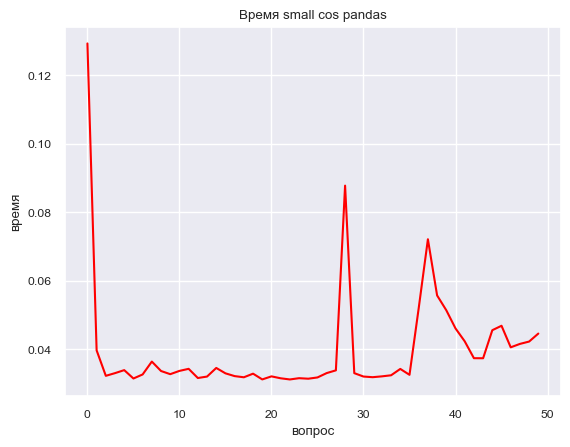

In [158]:
# Протестируем время извлечения ответов на 50 значениях + маленький датасет
sns.set_theme(palette ='pastel', font_scale=0.8)
t =  test(vectors, small, 'cos')
mean = sum(t)/len(t)
result_time['small_cos_pandas'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small cos pandas")
plt.xlabel('вопрос')
plt.ylabel('время');

In [68]:
# тест big cosine
%time
results = search_(query, big, 'cos', w2v_rag_1536, top_k=1)
print(results)

CPU times: user 3 μs, sys: 3 μs, total: 6 μs
Wall time: 24.8 μs
                                             context_vec
47184  [-0.009879556, -0.0032072135, 0.009872427, 0.0...


Среднее время извлечения ответа: 0.8537402248382568


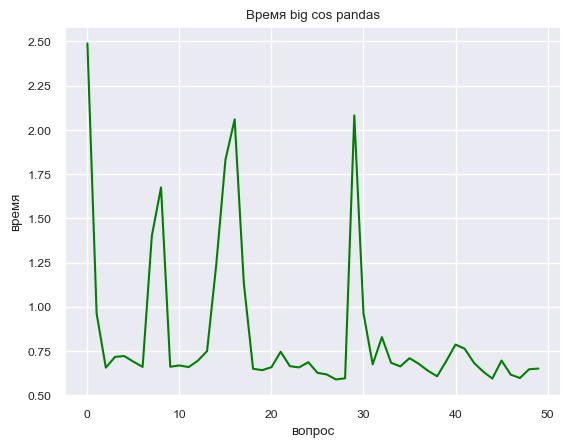

In [159]:
# Протестируем время извлечения ответов на 50 значениях + большой датасет
t =  test(vectors, big, 'cos')
mean = sum(t)/len(t)
result_time['big_cos_pandas'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big cos pandas")
plt.xlabel('вопрос')
plt.ylabel('время');

Поиск по эвклидову расстоянию

Среднее время извлечения ответа: 0.043849091529846194


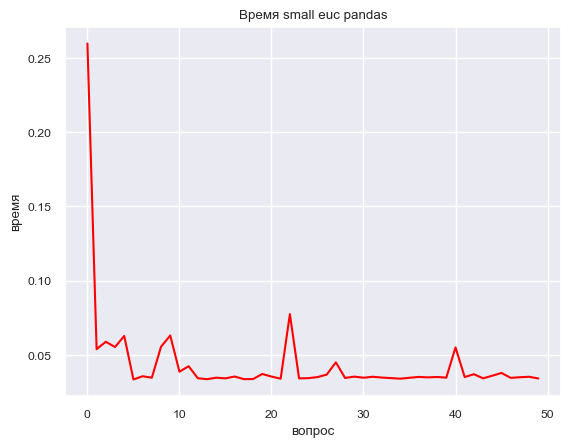

In [160]:
t =  test(vectors, small, 'euc')
mean = sum(t)/len(t)
result_time['small_euc_pandas'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color = 'red').set_title("Время small euc pandas")
plt.xlabel('вопрос')
plt.ylabel('время');

Среднее время извлечения ответа: 0.5548609447479248


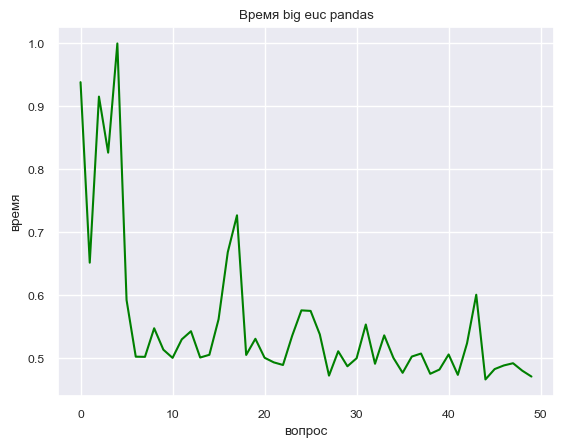

In [162]:
t =  test(vectors, big, 'euc')
mean = sum(t)/len(t)
result_time['big_euc_pandas'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color = 'green').set_title("Время big euc pandas")
plt.xlabel('вопрос')
plt.ylabel('время');

Выводы: при увеличении датасета в 10 раз время поиска ответа возрастает примерно в 10 раз. Если на ~12 тыс данных извлечение происходит в среднем за 0.1 секунду, то на большом в 120 000 примерно за 1 - 1.4 секунды, в зависимости от метода подсчета близости.

## QDRANT

In [73]:
%pip install -U qdrant-client
clear_output()

In [ ]:
from qdrant_client import models, QdrantClient
from qdrant_client.models import VectorParams, Distance

Загрузка готовых эмбеддингов w2vec в **qdrant**

### search_04 exact

Эксперименты со временем по большому и маленькому датасету

In [75]:
small['id'] = small.index
big['id'] = big.index
small.shape, big.shape

((11981, 2), (111981, 2))

In [76]:
qdrant = QdrantClient(url = "http://localhost:6333")

#### Эксперимент с Distance.COSINE маленький датасет

In [ ]:
# Создание коллекции
qdrant.recreate_collection(
    collection_name="small",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
    ),
)

# загрузка данных в базу
qdrant.upload_points(
    collection_name="small",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)

qdrant.count(
    collection_name='small',
    exact=True,
)

CountResult(count=11981)

In [ ]:
# функция для тестирования среднего времени извлечения ответа на 50 вопросах
# запускаем её на списке векторов из ранее сформированного набора случайных вопросов
# на выходе получаем список с временем для отрисовки
def test_q(vectors, collect):
    plt = []
    for test_query in vectors:
        start = time.time()
        qdrant.search(
        collection_name=collect,
        query_vector=test_query,
        limit=1,)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.008340625762939454


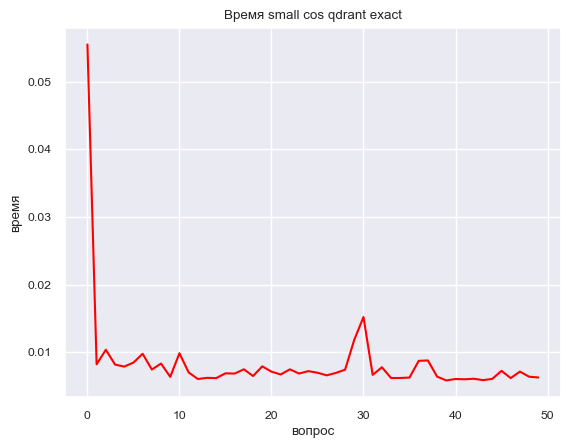

In [165]:
# Протестируем время извлечения ответов на 50 значениях
t =  test_q(vectors, 'small')
mean = sum(t)/len(t)
result_time['small_cos_qdrant_exact'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small cos qdrant exact")
plt.xlabel('вопрос')
plt.ylabel('время');

#### Эксперимент с Distance.DOT маленький датасет

In [ ]:
# Создание коллекции
qdrant.recreate_collection(
    collection_name="small_dist",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.DOT,
    ),
)

# загрузка данных в базу
qdrant.upload_points(
    collection_name="small_dist",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)



qdrant.count(
    collection_name='small',
    exact=True,
)

Среднее время извлечения ответа: 0.009940104484558105


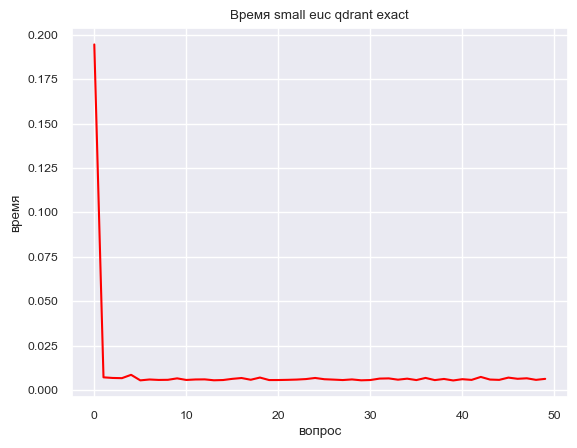

In [164]:
# Протестируем время извлечения ответов на 50 значениях
t =  test_q(vectors, 'small_dist')
mean = sum(t)/len(t)
result_time['small_dist_qdrant_exact'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small euc qdrant exact")
plt.xlabel('вопрос')
plt.ylabel('время');

#### Эксперимент с Distance.COSINE большой датасет

In [ ]:
# Создание коллекции
qdrant.recreate_collection(
    collection_name="big",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
    ),
)

# загрузка данных в базу
qdrant.upload_points(
    collection_name="big",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in big.iterrows()
    ],
)


qdrant.count(
    collection_name='big',
    exact=True,
)

True

In [95]:
query = df_w2v_1536.question[110]
test_query = get_phrase_embedding(query, w2v_rag_1536)
query, test_query

('why is the fairport public library moving to a new location?',
 array([-0.07530392,  0.0643885 , -0.01327899, ..., -0.08938366,
         0.03563269,  0.06804655], dtype=float32))

In [96]:
# тест поиска
%time
hits = qdrant.search(
    collection_name='big',
    query_vector=test_query,
    limit=1,

)

CPU times: user 9 μs, sys: 8 μs, total: 17 μs
Wall time: 141 μs


Среднее время извлечения ответа: 0.036346230506896976


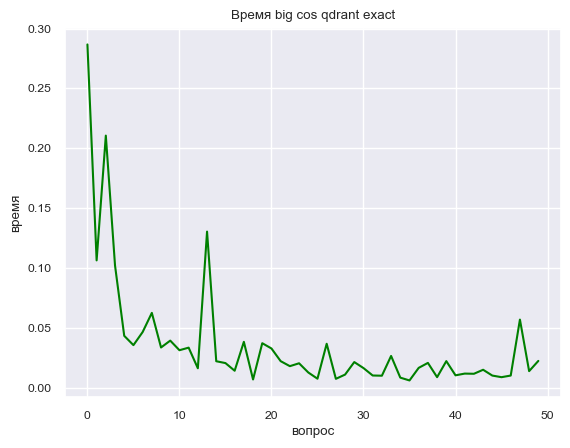

In [166]:
# Протестируем время извлечения ответов на 50 значениях
t =  test_q(vectors, 'big')
mean = sum(t)/len(t)
result_time['big_cos_qdrant_exact'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big cos qdrant exact")
plt.xlabel('вопрос')
plt.ylabel('время');

#### Эксперимент с Distance.DOT большой датасет

In [100]:
# Создание коллекции
qdrant.recreate_collection(
    collection_name="big_dist",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.DOT,
    ),
)

# загрузка данных в базу
qdrant.upload_points(
    collection_name="big_dist",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in big.iterrows()
    ],
)


qdrant.count(
    collection_name='big_dist',
    exact=True,
)

CountResult(count=111981)

Среднее время извлечения ответа: 0.06615833759307861


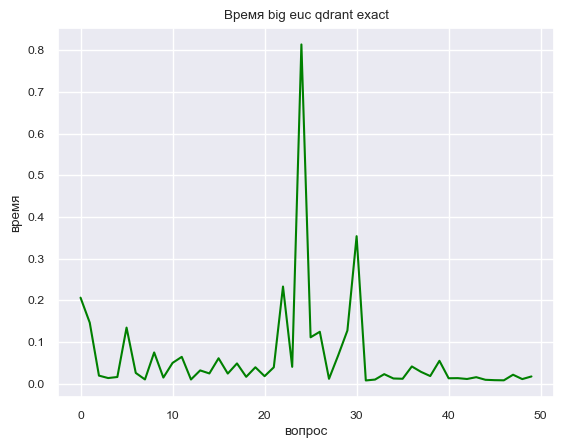

In [167]:
# Протестируем время извлечения ответов на 50 значениях
t =  test_q(vectors, 'big_dist')
mean = sum(t)/len(t)
result_time['big_dist_qdrant_exact'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big euc qdrant exact")
plt.xlabel('вопрос')
plt.ylabel('время');

Время извлечения ответа из БД 0.07 секунды на ~12 тыc строках, против 0.1 при работе с датафремом пандаc. Результат значительно лучше!!!
При том, что здесь используется exact поиск брутфорсом.

### search_05 qdrant HnswConfigDiff

Маленький датасет

#### Эксперимент с Distance.COSINE маленький датасет

Создаем новую коллекцию с использованием HnswConfigDiff

In [145]:
qdrant.recreate_collection(
    collection_name="small_hnsw",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=80,
)
    ),
        hnsw_config=models.HnswConfigDiff(
        ef_construct=100,
        full_scan_threshold=10000,
        max_indexing_threads=4,
        on_disk=True
    )
    )

qdrant.upload_points(
    collection_name="small_hnsw",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)

In [146]:
qdrant.count(
    collection_name="small_hnsw",
)

CountResult(count=11981)

Среднее время извлечения ответа: 0.010783753395080566


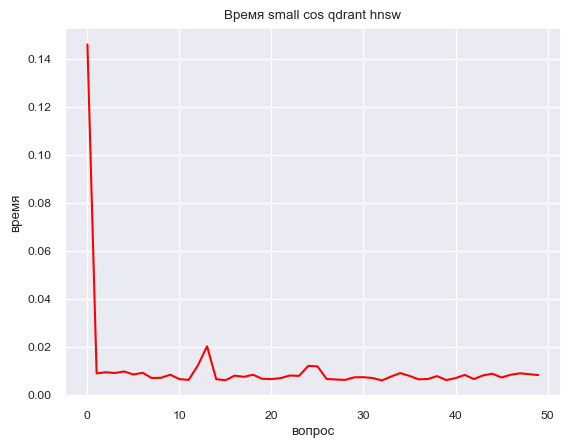

In [168]:
t =  test_q(vectors,'small_hnsw')
mean = sum(t)/len(t)
result_time['small_cos_qdrant_hnsw'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small cos qdrant hnsw")
plt.xlabel('вопрос')
plt.ylabel('время');

#### Эксперимент с Distance.DOT маленький датасет

Среднее время извлечения ответа: 0.00748830795288086


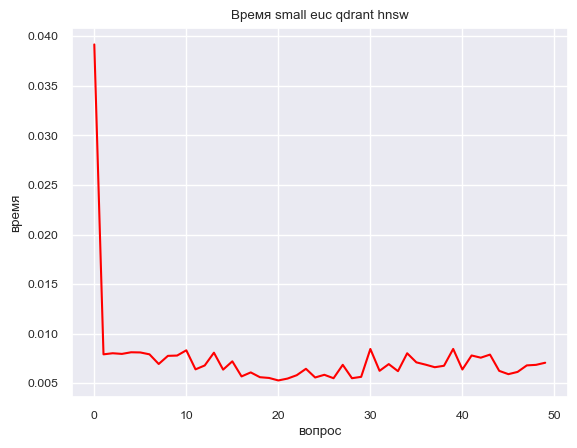

In [172]:
qdrant.recreate_collection(
    collection_name="small_hnsw_dist",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.DOT,
        hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=80,
)
    ),
        hnsw_config=models.HnswConfigDiff(
        ef_construct=100,
        full_scan_threshold=10000,
        max_indexing_threads=4,
        on_disk=True
    )
    )

qdrant.upload_points(
    collection_name="small_hnsw_dist",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)

t =  test_q(vectors,'small_hnsw_dist')
mean = sum(t)/len(t)
result_time['small_euc_qdrant_hnsw'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small euc qdrant hnsw")
plt.xlabel('вопрос')
plt.ylabel('время');

Большой датасет

#### Эксперимент с Distance.COSINE большой датасет

In [ ]:
qdrant.recreate_collection(
    collection_name="big_hnsw",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=100,
)
    ),
        hnsw_config=models.HnswConfigDiff(
        ef_construct=100,
        full_scan_threshold=10000,
        max_indexing_threads=4,
        on_disk=True
    )
)

qdrant.upload_points(
    collection_name="big_hnsw",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in big.iterrows()
    ],
)

In [110]:
qdrant.count(
    collection_name="big_hnsw",
)

CountResult(count=111981)

Среднее время извлечения ответа: 0.02886152744293213


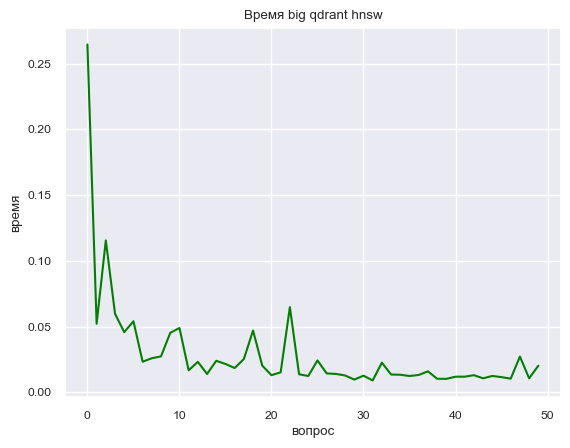

In [ ]:
t =  test_q(vectors,'big_hnsw')
mean = sum(t)/len(t)
result_time['big_cos_qdrant_hnsw'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big cos qdrant hnsw")
plt.xlabel('вопрос')
plt.ylabel('время');

#### Эксперимент с Distance.DOT большой датасет

In [173]:
qdrant.recreate_collection(
    collection_name="big_hnsw_euc",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.DOT,
        hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=100,
)
    ),
        hnsw_config=models.HnswConfigDiff(
        ef_construct=100,
        full_scan_threshold=10000,
        max_indexing_threads=4,
        on_disk=True
    )
)

qdrant.upload_points(
    collection_name="big_hnsw_euc",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in big.iterrows()
    ],
)

Среднее время извлечения ответа: 0.04629810810089111


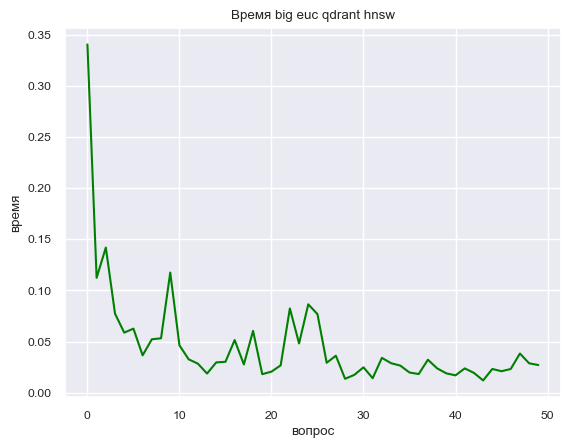

In [174]:
t =  test_q(vectors,'big_hnsw')
mean = sum(t)/len(t)
result_time['big_euc_qdrant_hnsw'] = mean
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big euc qdrant hnsw")
plt.xlabel('вопрос')
plt.ylabel('время');

## Выводы:

Таблица сравнения времени

In [176]:
result = pd.DataFrame(list(result_time.items()), columns=['search_method', 'mean_time'])
result = result.sort_values(by='mean_time').reset_index()
result.drop(columns='index', inplace=True)
result

,search_method,mean_time
0,small_euc_qdrant_hnsw,0.007488
1,small_cos_qdrant_exact,0.008341
2,small_dist_qdrant_exact,0.009940
3,small_cos_qdrant_hnsw,0.010784
4,big_cos_qdrant_hnsw,0.028862
5,big_cos_qdrant_exact,0.036346
6,small_cos_pandas,0.039806
7,small_euc_pandas,0.043849
8,big_euc_qdrant_hnsw,0.046298
9,big_dist_qdrant_exact,0.066158


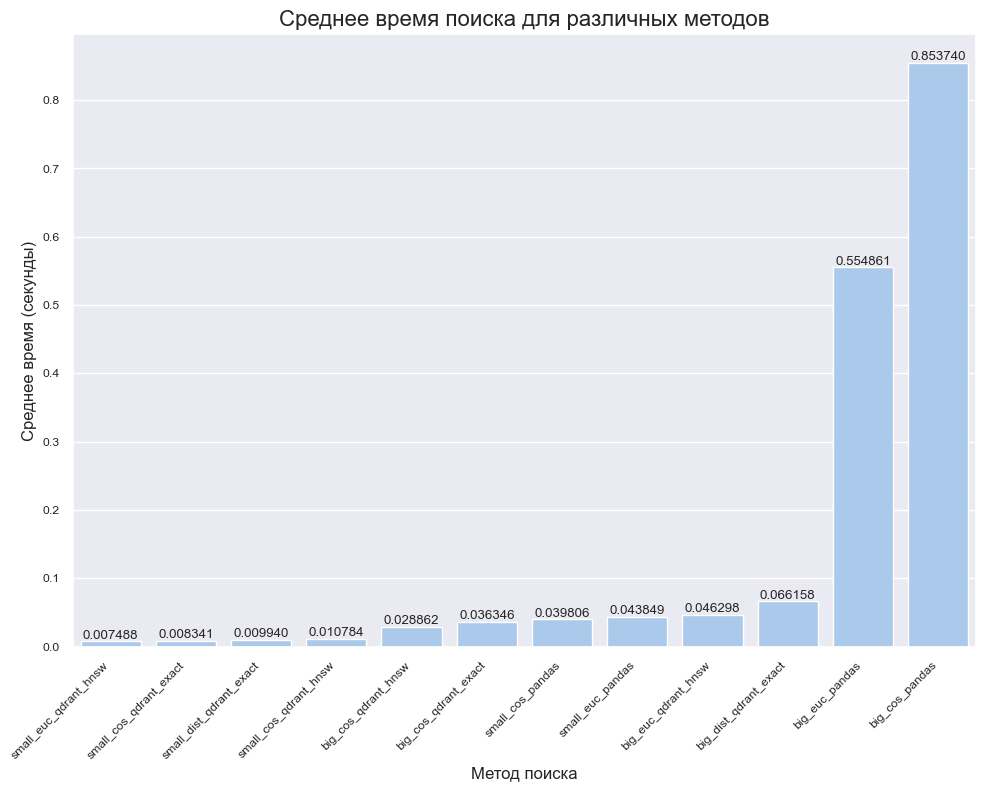

In [ ]:
# визуализация результирующей таблицы
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='search_method', y='mean_time', data=result)
plt.xticks(rotation=45, ha='right')
plt.title('Среднее время поиска для различных методов', fontsize=16)
plt.xlabel('Метод поиска', fontsize=12)
plt.ylabel('Среднее время (секунды)', fontsize=12)

for i, v in enumerate(result['mean_time']):
    ax.text(i, v, f'{v:.6f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Эксприменты проводились для dense векторов, которые были получены с помощью Word2Vec.

1. По качеству (точности поиска ответов) использование векторизации с помощью Word2Vec не устраивает.
2. По скорости работы с Word2Vec из датафрейма показывает, что чем больше данных, тем значительно медленнее идет извлечение. 12 тысяч 0.03 -0.04 секунды, 120 тысяч - 0.55-0.85 секунды в среднем.
3. Скорость извлечения векторов при использовании Qdrant значительно выше  - 0.007 - 0.009 на маленьком датасете, 0.02-0.03 на большом датасете, что быстрее, чем на маленьком датасетев  пандас! 
5. На большом датасете поиск с помощью hnssw отработал быстрее, чем exact
6. Использование метода подсчета близости векторов по косинусному сходству или эвклидово расстояние незначительно влияет на скорость извлечения ответов.
7. Далее планируется более подробгно изучить гибридный поиск